In [1]:
import os
import platform
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
os.getcwd()

'/Users/youngseoklee/Desktop/workplace/dacon_energy'

In [3]:
#파일경로 설정
if 'macOS' in platform.platform():
    path = '/Users/youngseoklee/Desktop/workplace/datas/dacon_energy/'
    print(path)
elif 'Linux' in platform.platform():
    path = '/workplace/datas/dacon_energy/'
    print(path)
else:
    print('어느 os에도 속해있지 않습니다')

/Users/youngseoklee/Desktop/workplace/datas/dacon_energy/


In [4]:
train_df = pd.read_csv(path + 'train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'test_df.csv', index_col=0)

sub = pd.read_csv(path + 'sample_submission.csv', index_col=0)

In [5]:
train_df.shape , test_df.shape

((204000, 27), (16800, 26))

In [6]:
train_df.keys()

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', 'Year',
       'Month', 'Day', 'Hour', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', 'PCS용량(kW)', '건물유형_건물기타', '건물유형_공공', '건물유형_대학교',
       '건물유형_데이터센터', '건물유형_백화점및아울렛', '건물유형_병원', '건물유형_상용', '건물유형_아파트',
       '건물유형_연구소', '건물유형_지식산업센터', '건물유형_할인마트', '건물유형_호텔및리조트'],
      dtype='object')

# Modeling

In [7]:
import torch
from torch import nn
from torch.nn import Transformer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
SEQUENCE_LENGTH = 24
TRAIN_SIZE = 0.8
BATCH_SIZE = 64

In [10]:


# Select all columns and convert to numpy array
X = train_df.drop('전력소비량(kWh)', axis=1).values
y = train_df['전력소비량(kWh)'].values



# Generate sequences
X = [X[i:i+SEQUENCE_LENGTH, :] for i in range(X.shape[0]-SEQUENCE_LENGTH)]
y = [y[i+SEQUENCE_LENGTH] for i in range(y.shape[0]-SEQUENCE_LENGTH)]
X, y = np.array(X), np.array(y).reshape(-1, 1)


In [11]:
X.shape, y.shape

# batch, seq_len, features /// 

((203976, 24, 26), (203976, 1))

In [12]:
# 0~203976

#data[0:24, : -1]
#data[1:25, : -1]
#.....
#data[203975 : 2~ , :-1]


In [13]:
# Split into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=False)

In [26]:

# Convert to PyTorch tensors and create dataloaders
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_data = TensorDataset(torch.from_numpy(test_df.values).float())

train_loader = DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)



In [15]:
#(B, Seq_len, C) (B, C)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((163180, 24, 26), (40796, 24, 26), (163180, 1), (40796, 1))

# Define Model

In [17]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, dff, input_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        
        self.fc1 = nn.Linear(input_dim, d_model)
        self.fc2 = nn.Linear(d_model, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        # Input Linear Transformation
        x = self.fc1(x)
        
        # Self Attention
        attn_output, _ = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        # Feed Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # Final Fully Connected Layers
        out2 = self.fc2(out2[:, -1, :])
        final_output = self.fc3(out2)

        return final_output

# Create the model instance
EPOCHS = 5
d_model = 64
num_heads = 4
dff = 256
input_dim = X_train.shape[-1]
##################################3


model = TransformerEncoder(d_model, num_heads, dff, input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

#train
for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        x, y = batch
        
        output = model(x)
        optimizer.zero_grad()

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for batch in val_loader:
            x, y = batch
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()
        print(f'Validation loss: {total_loss/len(val_loader)}')


Validation loss: 1599125.3990007837
Validation loss: 1677112.2254849137
Validation loss: 1410110.1818916537
Validation loss: 1335810.133473746
Validation loss: 1353339.9988979232


In [64]:
def predict(model, test_loader):
    model.eval()
    
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy().tolist())
    
    return predictions

In [63]:
for inputs in enumerate(test_loader):
    print(inputs)

(0, [tensor([[ 1.0000, 23.5000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 23.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 22.7000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000, 23.6000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 24.4000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 25.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])])
(1, [tensor([[ 1.0000, 25.1000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 24.9000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 24.5000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000, 18.1000,  3.7000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 17.9000,  1.3000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 18.0000,  1.2000,  ...,  0.0000,  0.0000,  0.0000]])])
(2, [tensor([[ 1.0000, 18.0000,  2.8000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 18.2000,  2.3000,  ...,  

In [65]:
pred = predict(model, test_loader)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [21]:
len(pred)

40796

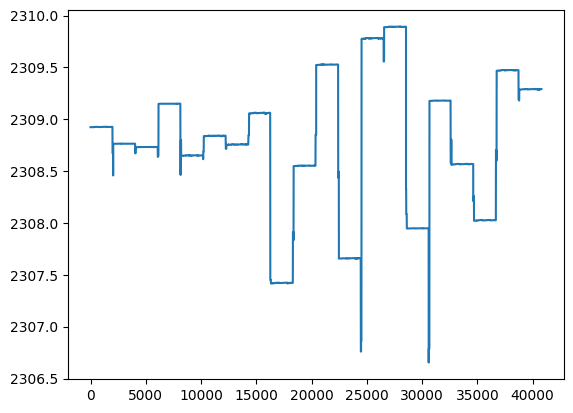

In [24]:
import matplotlib.pyplot as plt


plt.plot(pred)
plt.show();